In [190]:
import matplotlib
#matplotlib.use("TkAgg")
from scipy.io import wavfile
from scipy import signal
from scipy.signal import blackman
#from matplotlib import mlab
from matplotlib import pyplot as plt
import numpy as np
#from numpy.lib import stride_tricks
from pylab import *
from struct import pack
#import pywt
from scipy.fftpack import dct
#from struct import pack
import wave
from scipy.io import wavfile
import os
#import glob

import gc
import multiprocessing as mp
import resource 
import csv
import itertools

import pandas as pd
import ipywidgets as widgets

gc.enable()

flag = 0
date = "20220427"#'20211125'#'20210401'
data_path = 'data/'
mono_path = data_path + "wav/"
stereo_path = data_path + "stereo/"
dist_path = data_path + "dist/"

mono_file_path = mono_path + date + "/"
stereo_file_path = stereo_path + date + "/"

sweep_path = data_path + "sweep/"
sweep_time_path = sweep_path + date + "/"

aud_path = data_path + "aud_times/"
aud_time_path = aud_path + date + "/"

visual_path = 'visual/'
data_seg_path = 'processed/data_segments/'

samplerate = 192000
millispersample = (1/samplerate)*(10**3)

In [191]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:75% !important; }</style>"))

%config IPCompleter.greedy=True

In [192]:
def mem():
    print('Memory usage  : %2.2f MB' %round(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0,1))

In [193]:
mem()

Memory usage  : 7648.40 MB


# Create the necessary folder structure

In [194]:
import os
def create_folder_structure():
    if not os.path.exists("processed"):
        os.mkdir("processed",0o777)
        
    #sess = envs[1:]    
    if not os.path.exists("processed/" + "data_segments"):
        os.mkdir("processed/" + "data_segments",0o777)
        
    if not os.path.exists("processed/" + "data_segments/"+date):
        os.mkdir("processed/" + "data_segments/"+date,0o777)
        
    if not os.path.exists("processed/" + "data_segments/"+date+"/"+session_name):
        os.mkdir("processed/" + "data_segments/"+date+"/"+session_name,0o777)
        
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/left"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/left",0o777)
    
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/right"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/right",0o777)
        
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/left/sweep"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/left/sweep",0o777)
        
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/left/isweep"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/left/isweep",0o777)
        
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/left/18sine"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/left/18sine",0o777)
        
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/left/21sine"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/left/21sine",0o777)
    
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/right/sweep"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/right/sweep",0o777)
        
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/right/isweep"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/right/isweep",0o777)
        
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/right/18sine"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/right/18sine",0o777)
        
    if not os.path.exists("processed/data_segments/"+date+"/"+session_name+"/right/21sine"):
        os.mkdir("processed/data_segments/"+date+"/"+session_name+"/right/21sine",0o777)


# Make stereo wav files from mono

In [7]:
def make_stereo():
    if not os.path.exists(stereo_file_path):
        os.mkdir(stereo_file_path,0o777)

    for filename in os.listdir(mono_file_path):
        print (filename)
        samplerate, data = wavfile.read(mono_file_path + filename)
        rate = samplerate
        samples = len(data) 

        data_l = data.reshape(int(samples/2),2)[::2]
        data_r = data.reshape(int(samples/2),2)[1::2]

        wv = wave.open(stereo_file_path + filename,'w')
        wv.setparams((2, 2, rate, 0, 'NONE', 'Uncompressed'))

        wvData = np.hstack((data_l.reshape(-1, 1), data_r.reshape(-1,1)))

        wv.writeframes(wvData)
        wv.close()
        gc.collect()

    print ('All wav files have been converted to dual channel stereo')

# Read capture_time.txt

In [9]:
def read_capture_time():
    sessions = []
    f = open(data_path + "capture_time.txt")
    for rows in f.read().splitlines():
        sessions.append(rows.split('-'))

    f.close()
    return sessions

# Selected the required sessions

In [64]:
def pick_sessions(sessions):
    session_list = []
    line_no = 0
    for row in sessions:
        if row[0] != '' and row[1] != '':
            starttime = datetime.datetime.strptime(row[0],'%Y/%m/%d %H:%M:%S.%f')
            endtime = datetime.datetime.strptime(row[1],'%Y/%m/%d %H:%M:%S.%f')
        #print starttime
        if starttime.date() == datetime.datetime.strptime(date,'%Y%m%d').date() : #Check if sessions available which matches the experiment date
            line_no = line_no + 1
            print ("(", line_no, ")", "\t", starttime, "-", endtime)
            #session_list.append(row[0] + "-" + row[1])
            session_list.append([starttime,endtime])

    #print ("Plese register", str(ex[0]))
    print ("Please input the session numbers. Separate them with commas. Confirm the start and end times using the experiment note.")
    session = input("Session ") 
    print ("You have chosen the sessions ", session)
    return session_list, session

# Process the selected sessions

In [62]:
def get_selected_sessions(session_list, session):
    session = session.split(",")

    session = list(map(int,session))

    selected_session =[]
    for s in session:
        selected_session.append(session_list[s-1])

    session_name = selected_session[0][0].strftime('%Y%m%d%H%M%S%f')[:-3]+ "-" + selected_session[0][1].strftime('%Y%m%d%H%M%S%f')[:-3]
    return selected_session

# Make the wav file list

In [79]:
def wav_list_maker():
    file_list = []
    for s in selected_session:
        for filename in os.listdir(stereo_file_path):
            t = filename.split('.')[0]
            filetime = datetime.datetime.strptime(t,'%Y%m%d_%H%M%S_%f')
            if filetime >= s[0]- datetime.timedelta(seconds=1) and filetime <= s[1] + datetime.timedelta(seconds=1):#add seconds occationally
                file_list.append(filename)
                
    file_list.sort()
    return file_list

# Make the distance file list

In [13]:
def get_dist_file():
    file_list = []
    for s in selected_session:
        for filename in os.listdir(dist_path):
            t = filename.split('.')[0]
            filetime = datetime.datetime.strptime(t,'%Y%m%d%H%M%S')
            if filetime >= s[0]- datetime.timedelta(seconds=1) and filetime <= s[1] + datetime.timedelta(seconds=1):#add seconds occationally
                file_list.append(filename)
    return file_list

# Read relavant stereo wav files and concatanate according to the session

In [14]:
def separate_stereo():
    data_left = []
    data_right = []

    for audio_file in wav_filelist:#os.listdir(stereo_file_path):
        #audio_file = "20210906_171503_622.wav"
        #print(audio_file)
        #samplerate, data = wavfile.read('20171025/data/' + filename)
        audio_name = os.path.splitext(audio_file)[0]


        samplerate, data = wavfile.read(stereo_file_path + audio_file)

        data_left.extend(data[:, 0])
        data_right.extend(data[:, 1])
        #break
    data_left = np.array(data_left)
    data_right = np.array(data_right)
    return data_left, data_right

# Bandpass filter

In [15]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_signal(sweep_signal):
    #filtered_sweep_signals = []
    #print sweep_signals
    #for sig in sweep_signals:
    filtered_sweep_signals = butter_bandpass_filter(sweep_signal,17000,22000,samplerate)
    return filtered_sweep_signals

# Visualize the FFT spectrogram

In [16]:
def visualize_fft(data, low, high, NFFT):
    times = np.arange(len(data))/float(samplerate)

    plt.close("all")

    Fs = 192000#5000*2.#10000.
    NFFT = NFFT#4096
    noverlap = NFFT - NFFT/10#NFFT /2 #fft size
    pad_to = NFFT * 16
    dynamicRange = 30#30 #change this to change the color scale. 
    vmin = 20*np.log10(np.max(data)) - dynamicRange

    #window=blackman(NFFT)
    #window=signal.nuttall(NFFT)
    #window=np.hamming(NFFT)
    window = np.hanning(NFFT)

    cmap = plt.get_cmap('magma')

    vmin = data_right.min()
    vmax = data_right.max()

    Pxx, freqs, times, cax = plt.specgram(data, NFFT=NFFT, window=window,vmin=-50, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', pad_to=pad_to, cmap=cmap)
    #print(len(Pxx))
    #Pxx_left, freqs_left, times_left, cax_left = plt.specgram(data_left, NFFT=NFFT, window=window, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', vmin=75, pad_to=pad_to, cmap=cmap)
    #Pxx_right, freqs_right, times_right, cax_right = plt.specgram(data_right, NFFT=NFFT, window=window, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', vmin=75, pad_to=pad_to, cmap=cmap)
    #Pxx = np.absolute(np.subtract(Pxx_left,Pxx_left))
    #print Pxx
    #f, t, Sxx = signal.spectrogram(data_right, Fs)

    #print type(Pxx)
    #plt.figure(figsize=(20,10))
    #plt.figure(figsize=(20,10))
    axes_spec = plt.gca()
    #axes_spec.set_xlim([2.8, 7.5])
    axes_spec.set_ylim([low, high])#18500])

    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    #plt.pcolormesh(t, f, Sxx, vmax = 1e-6)
    #plt.show()

    plt.colorbar(cax, label='(dB)').ax.yaxis.set_label_position('left')

    plt.tight_layout()
    plt.show()
    #plt.savefig('swave_sweep.png',dpi=600)
    return Pxx, freqs, times

# Get beep start sample

In [94]:
def get_beep_time(data):
    dist_pxx,dist_freqs,dist_times = visualize_fft(data[int(0*192000):int(5*192000)], 0,1500,4096)
    beepfft = pd.DataFrame(dist_pxx,index=list(dist_freqs))
    
    beepwin = 50
    beepfft = beepfft.loc[beepfft.index<1500]
    beepfft = beepfft.T.rolling(beepwin).mean().T
    beepfft.fillna(0,inplace=True)
    
    beepmax = np.argmax(beepfft.iloc[300])-beepwin
    truthstart = int(beepmax*4096*0.1)
    
    return truthstart

# Read dist list

In [98]:
def read_dist_list(dist_file):
    dist_list = pd.read_csv(dist_path+"/"+dist_file[0], header=None)
    dist_list.columns=["millis","dist"]
    dist_list.dist.where(dist_list.dist <= 500, None, inplace=True)
    
    return dist_list

# Get velocity estimation

In [148]:
def get_velocity_estimation(dist_list):
    wsize = 10
    velocity_list = []
    for x in range(len(dist_list)):
        #Distance
        dist_window = dist_list.dist[x:x+wsize].values
        dist_window = dist_window[~np.isnan(dist_window)]
        try:
            distance = (dist_window.max() - dist_window.min())/100
        except:
            distance = 0

        #Time
        time_window = dist_list.millis[x:x+wsize].values
        time_window = time_window[~np.isnan(time_window)]
        time = (time_window[-1] - time_window[0])/1000

        velocity_list.extend([distance/time])
        
    dist_list = pd.concat([dist_list, pd.DataFrame(velocity_list)], axis=1)
    dist_list.columns = ["millis", "dist", "med", "sd", "velocity"]
    
    return dist_list

# Median filter to smoothen out the distance curve

In [134]:
def median_filter(data):
    wsize = 10
    median_data = []
    std_data = []
    for x in range(len(data)):
        data_window = data.dist[x:x+wsize]
        std_data.append(data_window.std())
        median_data.append(data_window.median())
    #display(data)
    data_all = pd.concat([data,pd.DataFrame(median_data),pd.DataFrame(std_data)], axis=1)
    #display(data_all)
    data_all.columns = ["millis", "dist", "med", "sd"]
    return data_all

# Save data

In [21]:
def save_data(data, path):
    pd.DataFrame(data).to_csv(path, header=False, index=False)

# Concat distance and velocity columns and save

In [39]:
def get_truth():
    velocity_list = pd.DataFrame(get_velocity_estimation(velocity_list))
    velocity_list.columns = ['velocity']
    truth = pd.concat([dist_list,velocity_list],axis=1)
    save_data(truth,"processed/data_segments/"+date+"/"+session_name+"/"+"labels.csv")

# Get selected data

In [22]:
def select_data():
    selected_data = data_right[truthstart:int(12.5*192000)]
    return selected_data

# Get FFT outline

In [158]:
def fft_outline(selected_data):
    Pxx,freqs,times = visualize_fft(selected_data,17000,22000,4096)
    
    df_pxx = pd.DataFrame(Pxx, index = freqs)

    diff_pxx_1 = df_pxx.loc[17500:21500].diff(axis=1)
    diff_pxx_0 = df_pxx.loc[17500:21500].diff(axis=0)

    #normalize
    diff_pxx_1=(diff_pxx_1-diff_pxx_1.min())/(diff_pxx_1.max()-diff_pxx_1.min())
    diff_pxx_0=(diff_pxx_0-diff_pxx_0.min())/(diff_pxx_0.max()-diff_pxx_0.min())

    df = diff_pxx_0.idxmax()#pd.DataFrame(Pxx).max()
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

# Design a short segment of the estimation signal

In [23]:
def design_comp_wave(u,x,y,z):
    des_sweep = np.concatenate((np.full(u,1),np.arange(0.000001,1,1/x)[::-1],np.full(u,0),np.arange(0.000001,1,1/y),np.full(u,1),np.arange(0.000001,1,1/z)[::-1],np.full(u,0)))
    return des_sweep

# Normalize data by deviding it by max

In [24]:
def normalize_data(data):
    norm_data = data/np.max(data)
    return norm_data

# Paralelize the estimation process

In [170]:
import multiprocessing
import pandas as pd
from scipy.spatial import distance
import time
start_time = time.time()


def f(nor_df):
    #corr_list = []
    for u in range(114,122):
        for x in range(20,25):
            for y in range(20,25):
                for z in range(20,25):
                    designed_signal = design_comp_wave(u,x,y,z)
                    corr_list = []
                    #if(len(normalized_df[i:len(normalized_df)])>len(normalized_df[i:select_len*(p+1)])):
                    #    nor_df = normalized_df[i:select_len*(p+1)]
                    #else:
                    #    nor_df = normalized_df[i:len(normalized_df)]
                    #normalized_df = normalized_df[:int(len(designed_signal)/2)]
                    #nor_df = normalize_data(nor_df)
                    for j in range(len(designed_signal)):
                        if (len(designed_signal)>=len(nor_df)+j):
                            selected_seg = designed_signal[j:len(nor_df)+j]
                            #corr,_ = pearsonr(nor_df,selected_seg)
                            #corr, _ = fastdtw(selected_seg,nor_df)
                            corr = distance.euclidean(selected_seg,nor_df)
                            corr_list.append(corr)
                            #print(corr)
                            #plt.plot(nor_df)
                            #plt.plot(selected_seg)
                            
    max_cor = np.argmin(corr_list)##np.argmax(corr_list)#
    #print(max_cor)
    segment = designed_signal[max_cor:len(nor_df)+max_cor]
    #plt.figure(figsize=(8,5))
    #plt.plot(nor_df)
    #plt.plot(segment)
    #plt.show()
    return segment



#if __name__ == '__main__':
def estimate_sig(normalized_df):
    # Create pool with 4 processors
    pool = multiprocessing.Pool(len(os.sched_getaffinity(0)))
    print("check")
    jobs = []
    #for group in data['some_group']:
    i = 0
    p = 0
    app_sig = []   
    select_len = 90#int(len(designed_signal)/4)
    data = []
    while select_len*(p)<len(normalized_df):
        # Create asynchronous jobs that will be submitted once a processor is ready
        if(len(normalized_df[i:len(normalized_df)])>len(normalized_df[i:select_len*(p+1)])):
            nor_df = normalized_df[i:select_len*(p+1)]
        else:
            nor_df = normalized_df[i:len(normalized_df)]
        #normalized_df = normalized_df[:int(len(designed_signal)/2)]
        #nor_df = normalize_data(nor_df)
        data.append(nor_df.values)#data[data.some_group == group]


        i = select_len*(p+1)
        p=p+1

    for seg in data:
        jobs.append(pool.apply_async(f, (seg, )))
#print(i)
    # Submit jobs
    app_sig.extend(job.get() for job in jobs)

    approx_sig = np.concatenate(app_sig).ravel().tolist()

    # Combine results
    #approx_sig.extend(results)
    print("--- %s seconds ---" % (time.time() - start_time))
    return approx_sig

# Separate sines and sweeps

In [26]:
from statistics import mode
def look_both(x):
    window=2
    try:
        m = mode(approx_sig[x-window:x+window])
    except: m=None 
    return m

In [175]:
def separate_sig(approx_sig):
    sine18 = []
    s18 = []
    sw = []
    sweep =[]
    s21 = []
    sine21 = []
    #approx_sig = smooth(approx_sig)
    for x in range(len(approx_sig)):    

        #for 18kHz
        if(approx_sig[x]==0):
            s18.extend([x])
        elif look_both(x)==0:
            s18.extend([x])
            #print(s18)
        else:
            if s18:
                sine18.append(s18)
            s18 = []


        #for sweeps and peaks in 18kHz
        if(approx_sig[x]>0 and approx_sig[x]<1):
            sw.extend([x])
                #if s18:
                #    sine18.append(s18)
                #    print(s18)
                #s18 = []
        else:
            if sw:
                sweep.append(sw)
            sw = []


        #for 21kHz
        if(approx_sig[x]==1):
            s21.extend([x])
        else:
            if s21:
                sine21.append(s21)
            s21 = []
            
    sweep = [x for x in sweep if len(x)>20]
    
    return sine18, sweep, sine21

# Calculate spectrum

In [28]:
import pylab as pl

def calculate_spectrum(signal):
    rate = samplerate
    t = np.arange(0, 10, 1/rate)
    x = signal
    p = 20*np.log10(np.abs(np.fft.rfft(x)))
    f = np.linspace(0, rate/2, len(p))
    #print(len(p))
    #print(len(f))
    #print(f)
    #plt.plot(p[500:750])
    spectrum = pd.DataFrame(p)
    spectrum.index = f
    #display(spectrum[18000:21000])
    #spectrum[18000:21000].plot()
    #plot(f[18000:21000], p[18000:21000])
    #plt.show()
    return spectrum[17500:21500].T

# Visualize spectrum (No clear reason to use this)

In [29]:
def visualize_spec(data,NFFT,low,high,dynamicRange):#,name,n):
    times = np.arange(len(data))/float(samplerate)

    plt.close("all")

    Fs = 192000#5000*2.#10000.
    NFFT = NFFT#int(16384/2)#min(4096, len(data))#32768
    noverlap = NFFT - NFFT/10#NFFT /2 #fft size
    pad_to = NFFT * 16
    dynamicRange = dynamicRange#30 #change this to change the color scale. 
    #vmin = 20*np.log10(np.max(data)) - dynamicRange

    #window=blackman(NFFT)
    #window=signal.nuttall(NFFT)
    #window=np.hamming(NFFT)
    window = np.hanning(NFFT)

    cmap = plt.get_cmap('magma')

    #vmin = data_right.min()
    #vmax = data_right.max()

    Pxx, freqs, times, cax = plt.specgram(data, NFFT=NFFT, window=window,vmin=-50, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', pad_to=pad_to, cmap=cmap)
    #print(len(Pxx))
    #Pxx_left, freqs_left, times_left, cax_left = plt.specgram(data_left, NFFT=NFFT, window=window, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', vmin=75, pad_to=pad_to, cmap=cmap)
    #Pxx_right, freqs_right, times_right, cax_right = plt.specgram(data_right, NFFT=NFFT, window=window, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', vmin=75, pad_to=pad_to, cmap=cmap)
    #Pxx = np.absolute(np.subtract(Pxx_left,Pxx_left))
    #print Pxx
    #f, t, Sxx = signal.spectrogram(data_right, Fs)

    #print type(Pxx)
    #plt.figure(figsize=(20,10))
    #plt.figure(figsize=(20,10))
    axes_spec = plt.gca()
    #axes_spec.set_xlim([2.8, 7.5])
    axes_spec.set_ylim([low, high])#18500])

    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    #plt.pcolormesh(t, f, Sxx, vmax = 1e-6)
    #plt.show()

    plt.colorbar(cax, label='(dB)').ax.yaxis.set_label_position('left')

    plt.tight_layout()
    #plt.savefig("visual/20211021/us_bicycle_approaching/" + name + "_" +str(n)+".png")
    plt.show()
    return Pxx, freqs, times

# Generate sine sweep

In [30]:
from scipy.signal import chirp

def generate_sweep():
    x = 0
    if samplerate == 96000:
        x = 9600
    if samplerate == 192000:
        x = 19200
    
    
    f1 = 18000        # start frequency
    f2 = 21000       # end frequency
    fs = samplerate#96000      # sampling frequency
    T = 0.05          # time duration of the sweep
    t = float(x)/samplerate

    a = (f2 - f1)/float(T)

    t = np.arange(0,np.round(fs*T-1)/fs,1/fs)  # time axis
    sweep = np.sin(2*np.pi*((a*t**2)/2 + (f1*t)))
    #s = np.sin(2*np.pi*f1*np.exp(t)) 
    return sweep

# Calculate the envelop of the sweep

In [31]:
from scipy.signal import hilbert
def calc_envelop(cut):
    analytic_signal = hilbert(cut)
    amplitude_envelop = np.abs(analytic_signal)
    return amplitude_envelop

# Determine the gradient of the sweeps and determine if sweep or invers sweep

In [32]:
from scipy.stats import linregress
def determine_gradient(data):
    return linregress(np.arange(len(data)),data).slope

# Calculated impulse responses 

In [36]:
def get_ir():
    inverse_coef = 410
    sweepmillis_list = []
    generated_sweep = generate_sweep()
    corr = []
    corr_raw = []
    n=0
    name="sweep_IRs_"

    #Change data to either data_left or data_right
    #selected_data = data_left[int(3*192000):int(12.5*192000)]

    for y in sweep:
        try:
            data = selected_data[(y[0])*inverse_coef+int(4096*0.4):(y[-1])*inverse_coef+int(4096*0.6)]#selected_data[(y[0])*inverse_coef+int(4096*0.6):(y[-1])*inverse_coef+int(4096*0.6)]
        except:
            data = selected_data[(y[0])*inverse_coef+int(4096*0.4):(y[-1])*inverse_coef+int(4096*0.6)]#selected_data[(y[0])*inverse_coef+int(4096*0.4):(y[-1])*inverse_coef+int(4096*0.6)]

        data = data-mean(data) #Remove DC offset
        data = np.pad(data,(1000,1000),'constant')
        data = normalize_data(data) #Normalize data
    #     plt.title("Noicy data")
    #     plt.plot(data)
    #     plt.show()


        #data = filter_signal(data) #remove frequencies below 17000 and above 22000
        #calculate_spectrum(data).T.plot()
        #plt.show()


        data = normalize_data(data) #Normalize data
    #     plt.title("Filtered data")
    #     plt.plot(data)
    #     plt.show()


        estimated_sig= approx_sig[y[0]:y[-1]]
        gradient = determine_gradient(estimated_sig)
        #_,_,_ = visualize_fft(data,17500,21500,4096)

        #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        #generated_sweep = Tx/np.max(Tx)
        #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

        sweepmillis = (y[0]*inverse_coef+int(4096*0.4))*millispersample
        print("millis = ", sweepmillis)
        sweepmillis_list.append(sweepmillis)

        if gradient>0:
            print("*** Sweep ***")
            #_,_,_ = visualize_spec(data,1024,17500,21500)
            conv = np.convolve(data,generated_sweep[::-1],'full')
        elif gradient<0:
            print("*** Inverse sweep ***")
            #_,_,_ = visualize_spec(data[::-1],1024,17500,21500)
            conv = np.convolve(data,generated_sweep,'full')
        conv_cut = conv[conv.argmax():]
        envelop = calc_envelop(conv_cut)#hl_envelopes_idx(conv_cut)

        #Get distance data 
        lens = get_dist(len(envelop[:6000]))

        fig, ax = plt.subplots(figsize=(20,5))
        ax.plot(lens,envelop[:6000]/max(envelop[:6000]))
        #ax.set_xticklabels(list(lens))
        ax.axis(ymin=0,ymax=0.2)
        ax.grid()

        #plt.plot(envelop[:6000])
        #get_peaks(envelop[:6000]/envelop[:6000].max(),lens)
        #plt.plot(calculate_spectrum(envelop[:6000]))
        #plt.savefig("visual/20211021/us_bicycle_approaching/" + name +str(n)+".png")
        plt.show()
        #envelop2 = get_envelop(conv_cut)
        corr_raw.append(conv_cut)
        corr.append(envelop)
        n=n+1
    gc.collect()
    
    nc_raw = []
    nc = []
    for i in corr_raw:
        nc_raw.append(i[:6000]/max(i[:6000]))
    for i in corr:
        nc.append(i[:6000]/max(i[:6000]))
    
    return nc, sweepmillis_list

# Convert samples of each impulse response to distances

In [33]:
def get_dist(array_len):
    return np.arange(0,array_len,1)*0.18/2

# True distance values of each impulse response

In [34]:
def get_real_dist():
    sweep_dist = []
    for m in sweepmillis_list:
        sweep_dist.append(dist_list.loc[dist_list['millis'].sub(m).abs().idxmin()].dist)
    return sweep_dist

# Get true distance data for each impulse response

In [38]:
def true_ir_dist():
    ground_truth = []
    lens = get_dist(6000)
    for x in sweep_dist:
        temp = [0.0] * len(lens)
        ind = min(range(len(lens)), key=lambda i: abs(lens[i]-x))
        #print(ind)
        lower = ind - 10
        upper = ind + 10
        if lower<10: lower=10
        if upper>len(lens-10): upper=len(lens-10)
        temp[lower:upper] = [1.0] * (upper - lower) #temp[ind] = 1
        #print(temp)
        ground_truth.append(temp)
    return ground_truth

# Generating log function

In [186]:
def get_log(length):
    in_array = np.linspace(0, length, length)
    log_array = np.log(in_array + 1000)


    log_array = (log_array - np. min(log_array)) / (np. max(log_array) - np. min(log_array)) 

    #print("in_array : ", in_array)
    #print("\nout_array : ", log_array)

    # red for numpy.tanh()
    plt.plot(log_array, color = 'red')
    plt.title("numpy.log()")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    
    return log_array

# Generating hyperbolic tangent function

In [187]:
def get_tan(length):
    in_array = np.linspace(-np.pi, np.pi, length)
    tan_array = np.tanh(in_array + 2.5)#np.tanh(in_array + 2.5)
    #print("in_array : ", in_array)
    #print("\nout_array : ", tan_array)

    # red for numpy.tanh()
    plt.plot(tan_array, color = 'red')
    plt.title("numpy.tanh()")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    return tan_array

In [188]:
def get_modified_nc(nc, out_array):
    test = []
    for row in nc:
        test.append(row*out_array)
    return test

In [189]:
def get_normalized_nc(test):
    processed_ir = []
    for row in test:
        processed_ir.append((row - row.min())/(row.max() - row.min()))
    return processed_ir

20220427_191951_737.wav
20220427_191723_100.wav
20220427_191800_625.wav
20220427_191707_514.wav
20220427_191944_212.wav
20220427_191848_106.wav
20220427_191816_615.wav
20220427_191824_131.wav
20220427_191855_613.wav
20220427_191832_131.wav
20220427_191618_660.wav
20220427_191628_027.wav
20220427_191959_664.wav
20220427_191638_418.wav
20220427_191611_141.wav
20220427_191645_943.wav
20220427_191747_745.wav
20220427_191903_292.wav
20220427_191740_241.wav
20220427_191655_143.wav
20220427_191715_018.wav
All wav files have been converted to dual channel stereo
( 1 ) 	 2022-04-27 19:16:11.080000 - 2022-04-27 19:16:27.949000
( 2 ) 	 2022-04-27 19:16:38.166000 - 2022-04-27 19:16:55.098000
( 3 ) 	 2022-04-27 19:17:07.475000 - 2022-04-27 19:17:23.046000
( 4 ) 	 2022-04-27 19:17:40.004000 - 2022-04-27 19:18:00.602000
( 5 ) 	 2022-04-27 19:18:16.578000 - 2022-04-27 19:18:32.110000
( 6 ) 	 2022-04-27 19:18:47.863000 - 2022-04-27 19:19:03.248000
( 7 ) 	 2022-04-27 19:19:43.965000 - 2022-04-27 19:19:5

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7555: RuntimeWarning: divide by zero encountered in log10
  Z = 20. * np.log10(spec)


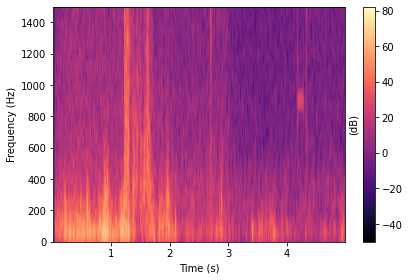

In [196]:
make_stereo()
sessions = read_capture_time()
session_list, session = pick_sessions(sessions)
selected_session = get_selected_sessions(session_list, session)
#create_folder_structure()
wav_filelist = wav_list_maker()
dist_filelist = get_dist_file()
data_left, data_right = separate_stereo()
truthstart = get_beep_time(data_right)

In [198]:
dist_list = read_dist_list(dist_filelist)
dist_list = median_filter(dist_list)

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [156]:
dist_list = get_velocity_estimation(dist_list)
#save_data(dist_list,"processed/data_segments/"+date+"/"+session_name+"/"+"labels.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


NameError: name 'session_name' is not defined

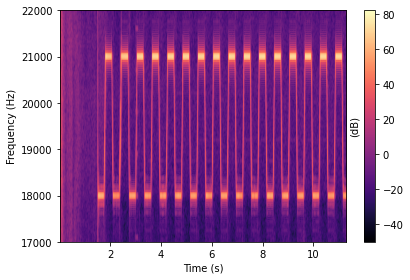

In [199]:
selected_data = data_right[truthstart:int(12.5*192000)]
Pxx,freqs,times = visualize_fft(selected_data,17000,22000,4096)

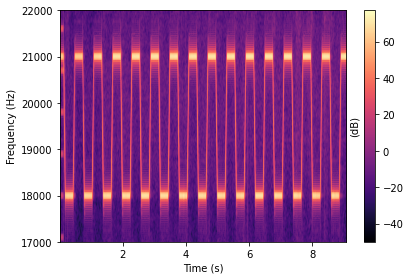

In [159]:
normalized_df = fft_outline(selected_data)

In [171]:
approx_sig = estimate_sig(normalized_df)

check
--- 83.03950691223145 seconds ---


In [176]:
sine18, sweep, sine21 = separate_sig(approx_sig)

millis =  119.57291666666666
*** Inverse sweep ***


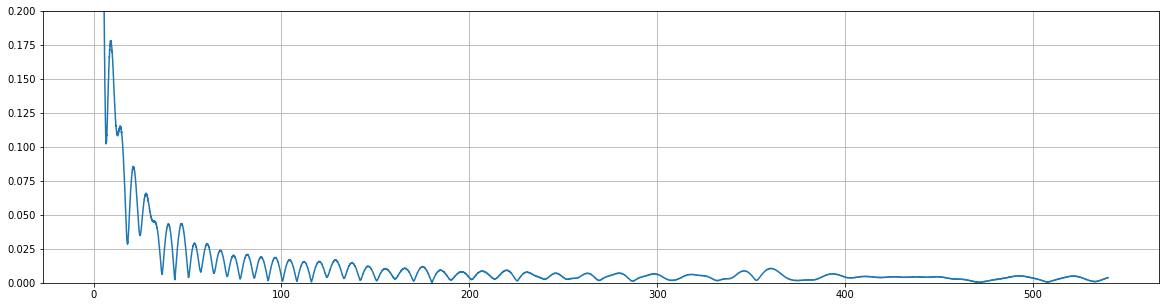

millis =  424.9375
*** Sweep ***


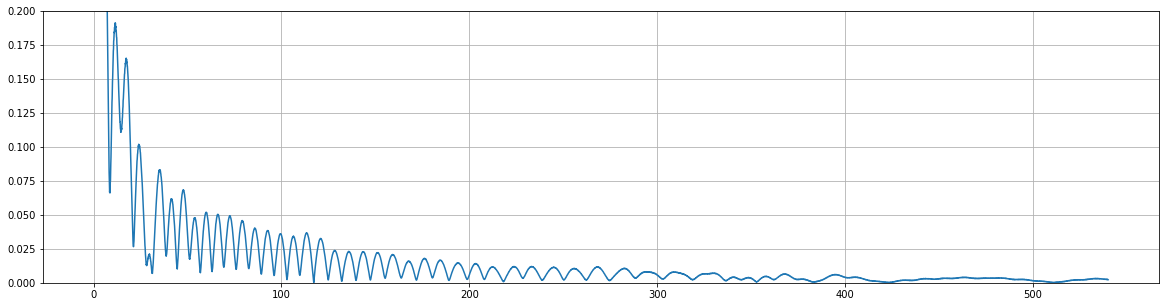

millis =  721.7604166666666
*** Inverse sweep ***


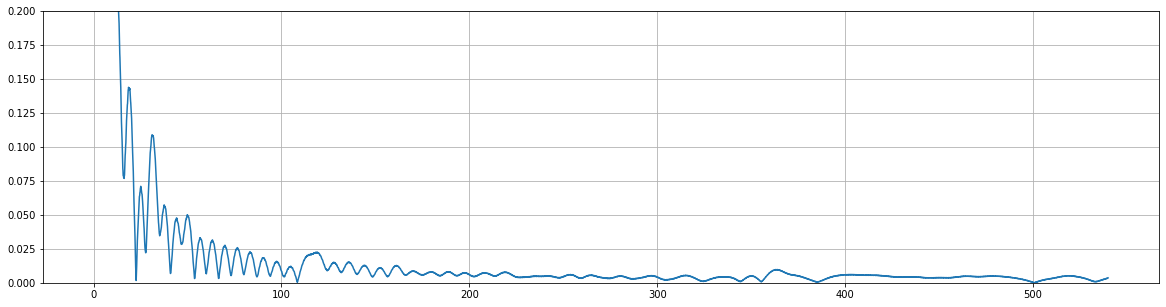

millis =  1024.9895833333333
*** Sweep ***


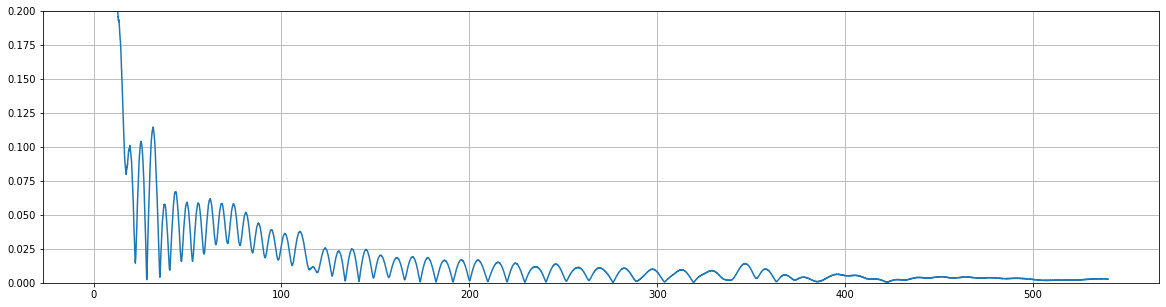

millis =  1321.8125
*** Inverse sweep ***


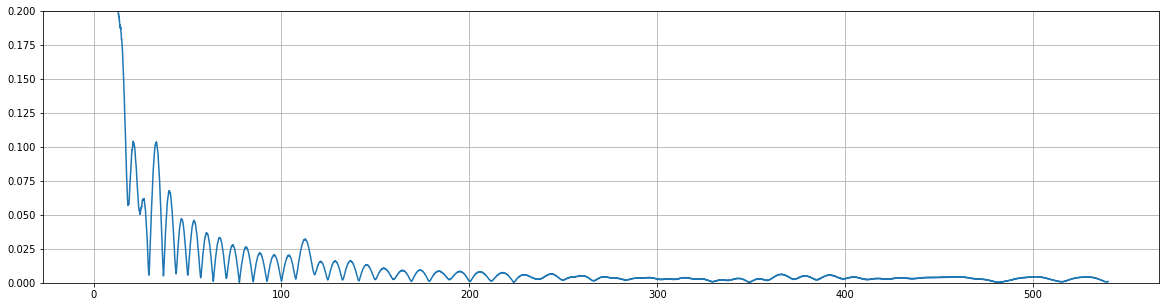

millis =  1625.0416666666665
*** Sweep ***


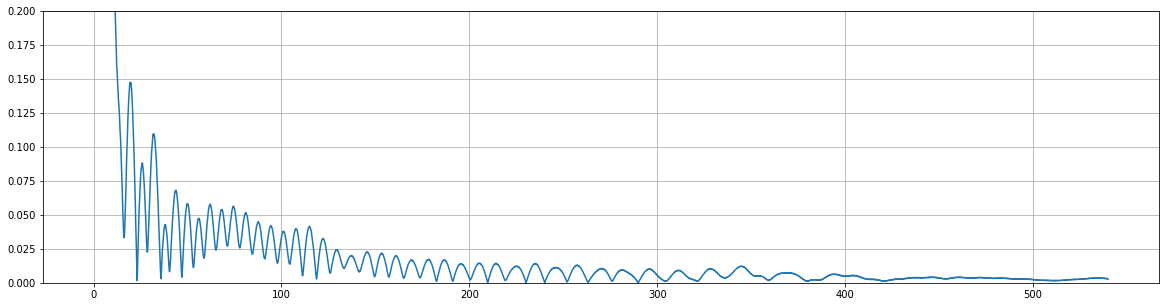

millis =  1924.0
*** Inverse sweep ***


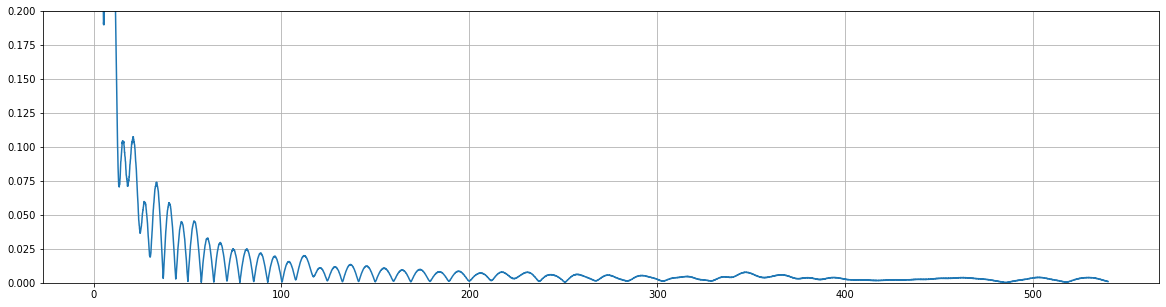

millis =  2225.09375
*** Sweep ***


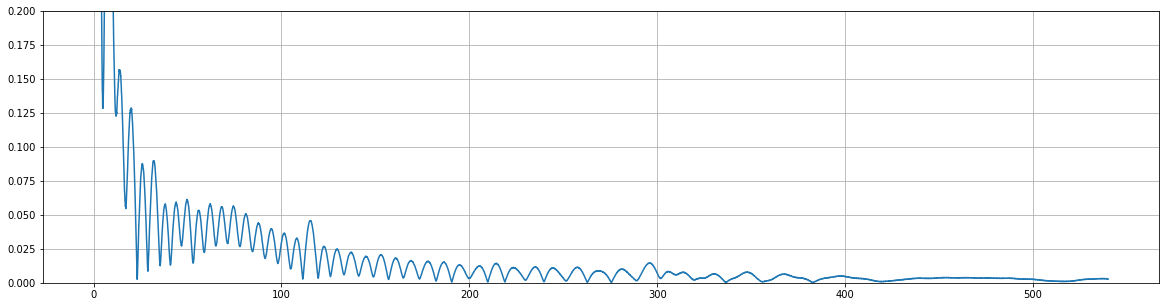

millis =  2519.78125
*** Inverse sweep ***


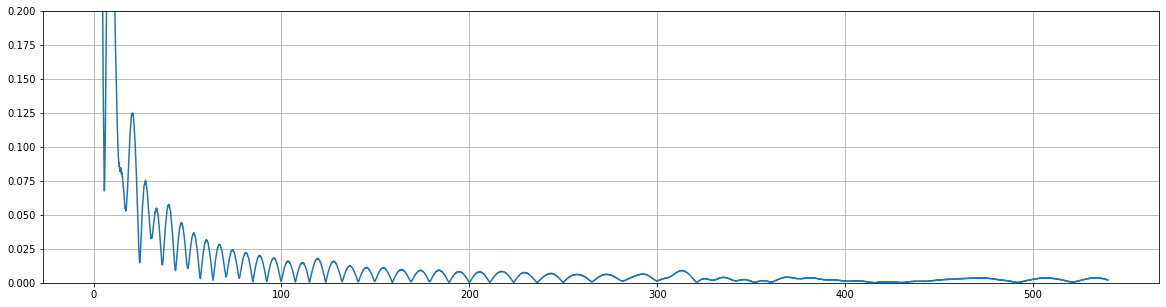

millis =  2825.145833333333
*** Sweep ***


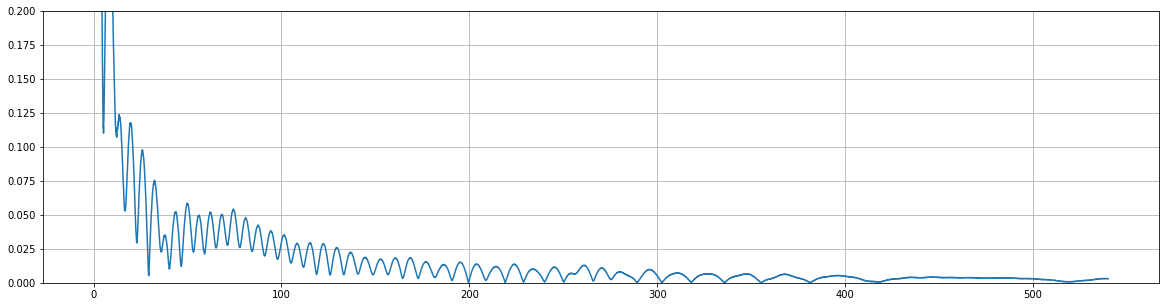

millis =  3119.833333333333
*** Inverse sweep ***


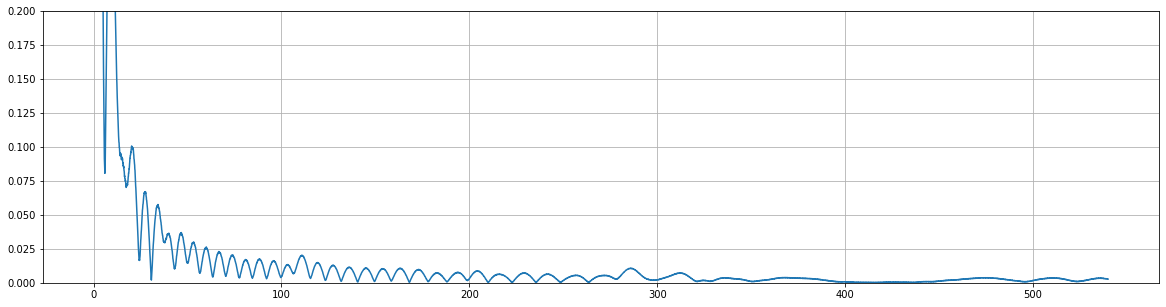

millis =  3427.333333333333
*** Sweep ***


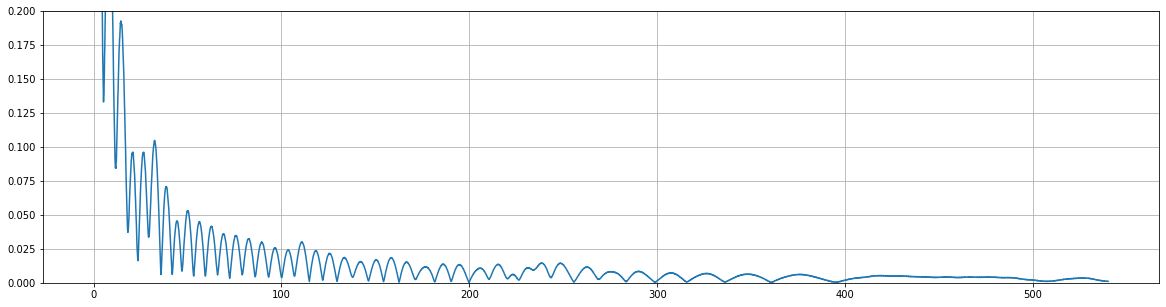

millis =  3719.8854166666665
*** Inverse sweep ***


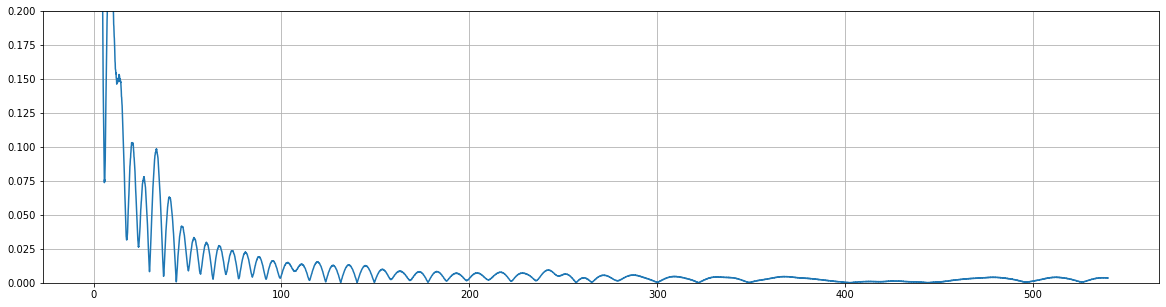

millis =  4027.3854166666665
*** Sweep ***


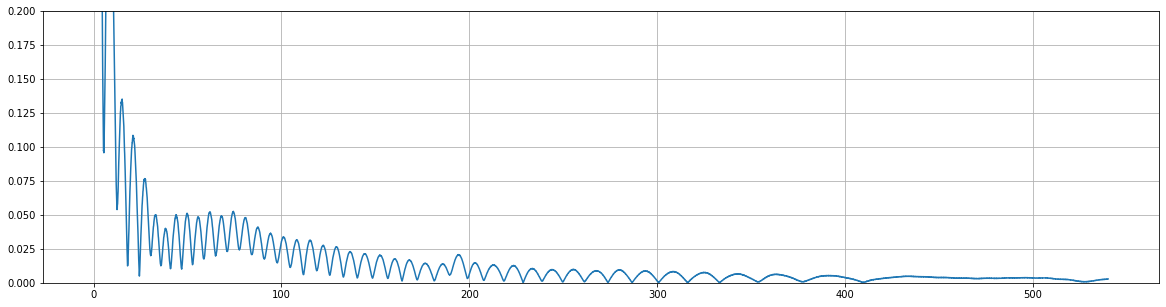

millis =  4319.9375
*** Inverse sweep ***


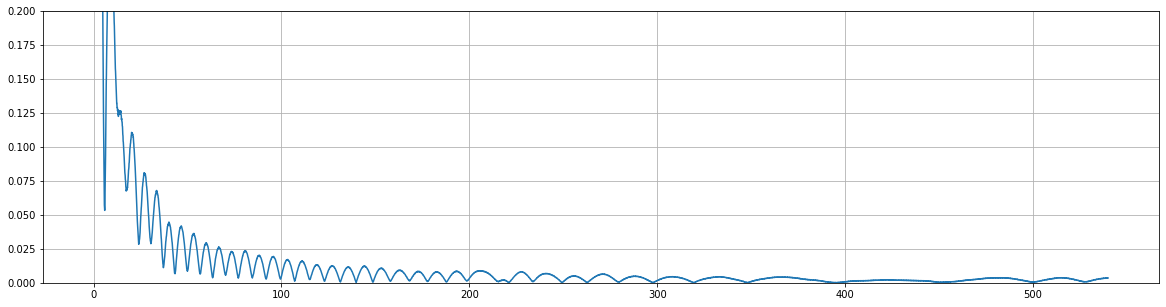

millis =  4625.302083333333
*** Sweep ***


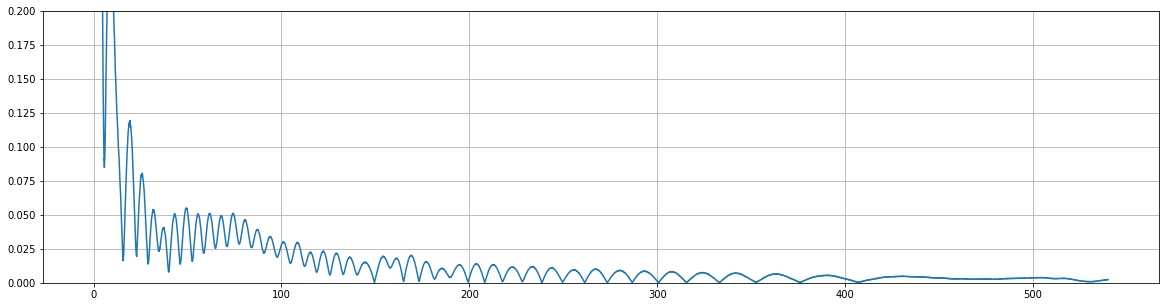

millis =  4919.989583333333
*** Inverse sweep ***


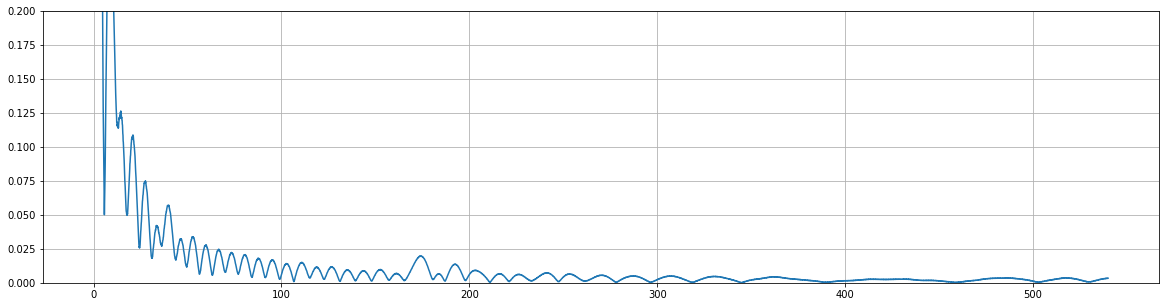

millis =  5225.354166666666
*** Sweep ***


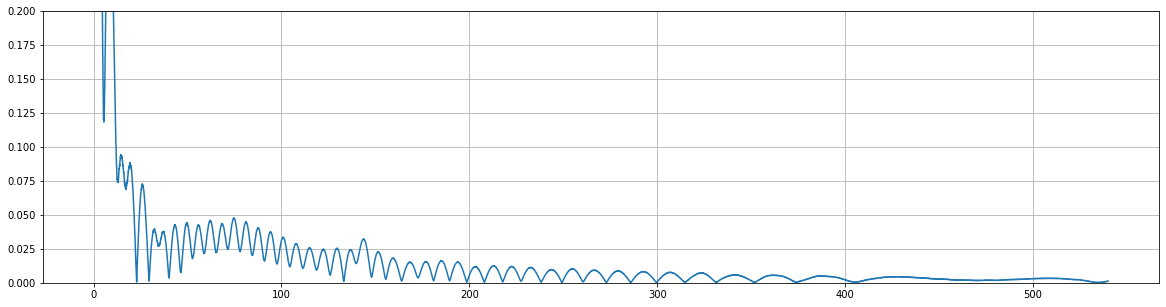

millis =  5520.041666666666
*** Inverse sweep ***


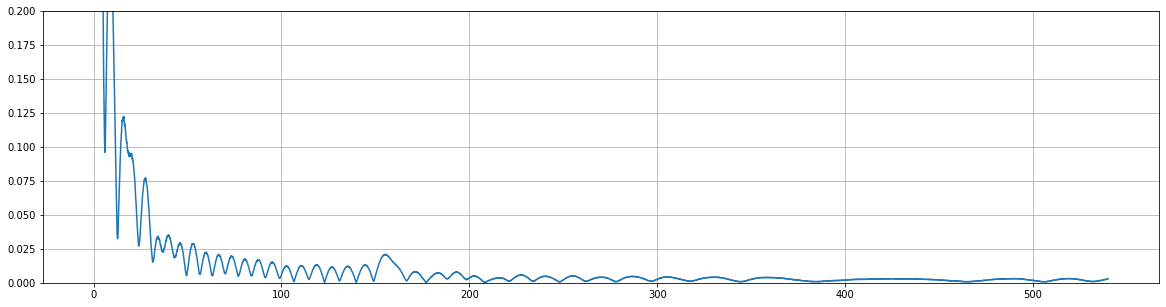

millis =  5825.40625
*** Sweep ***


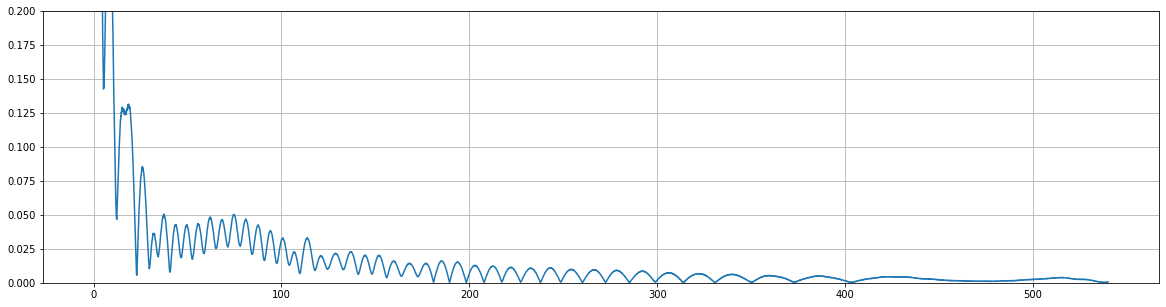

millis =  6120.09375
*** Inverse sweep ***


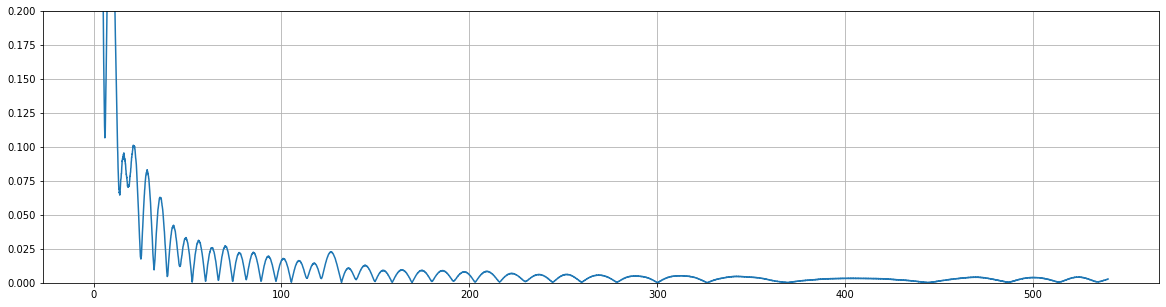

millis =  6425.458333333333
*** Sweep ***


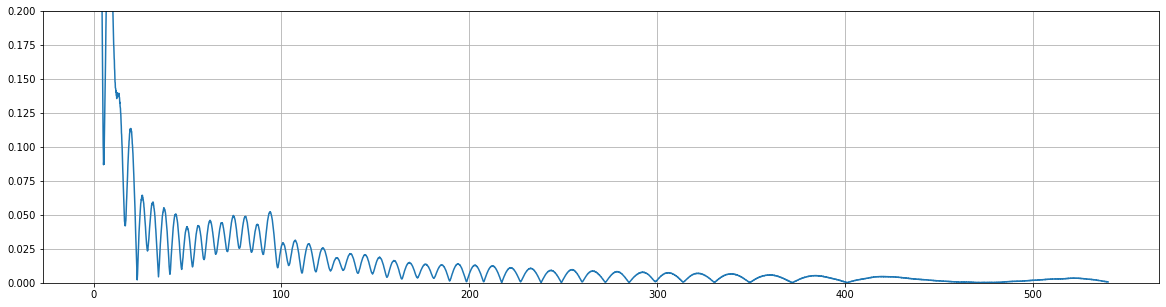

millis =  6722.28125
*** Inverse sweep ***


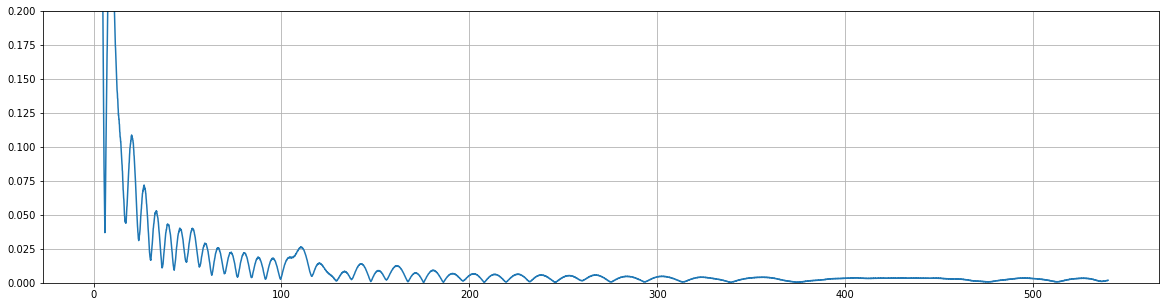

millis =  7025.510416666666
*** Sweep ***


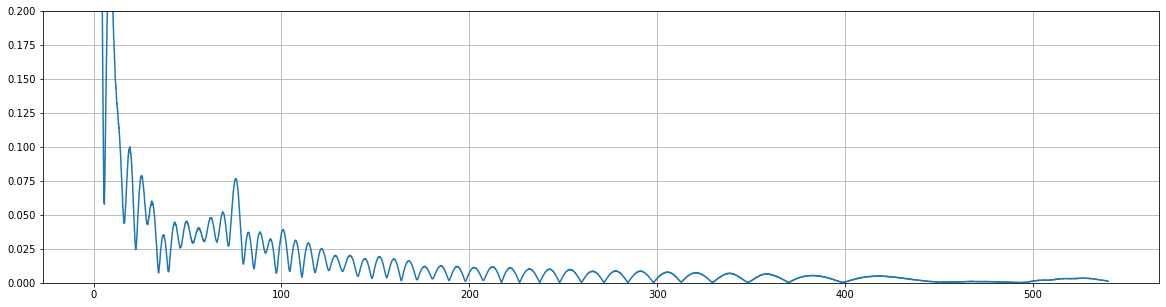

millis =  7320.197916666666
*** Inverse sweep ***


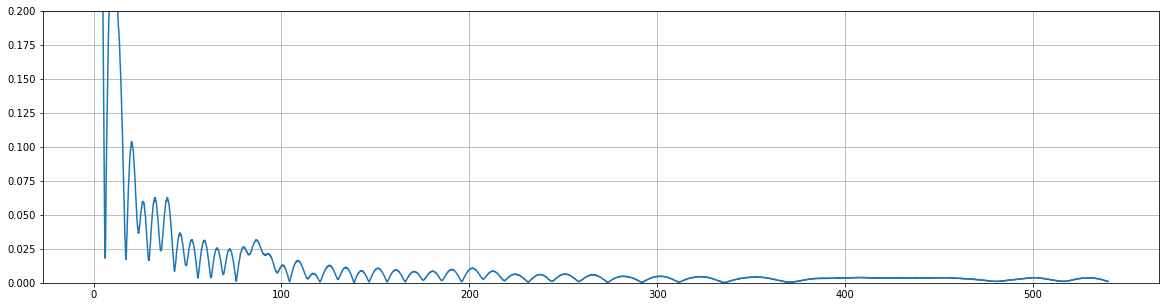

millis =  7625.5625
*** Sweep ***


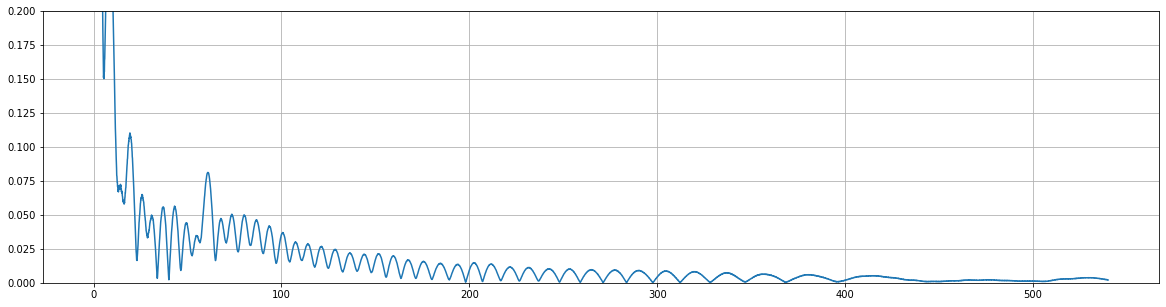

millis =  7920.25
*** Inverse sweep ***


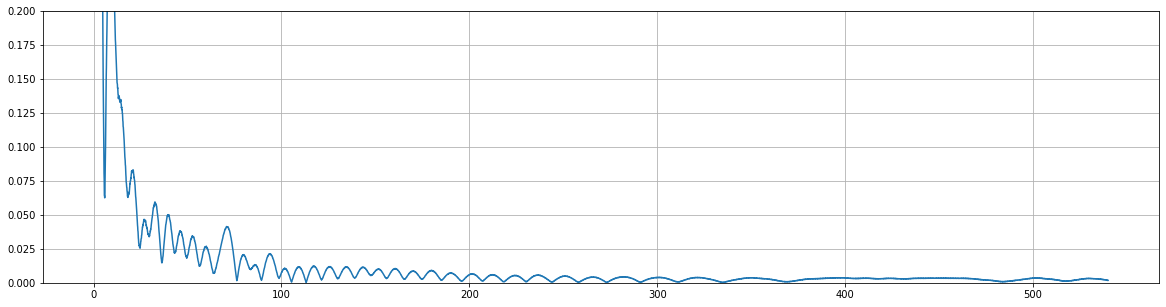

millis =  8225.614583333332
*** Sweep ***


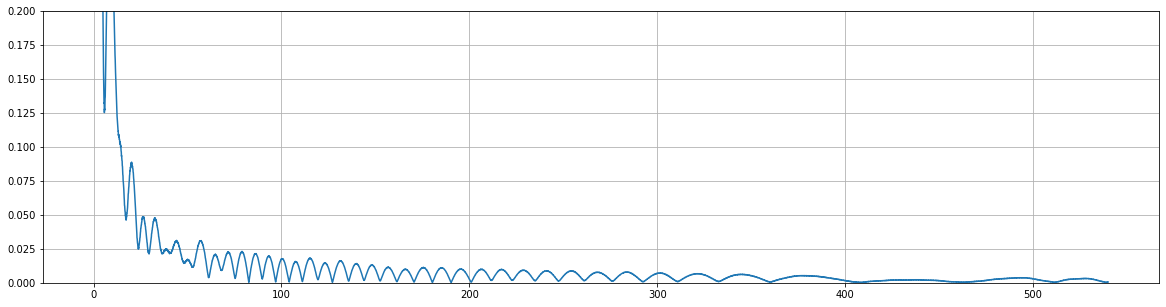

millis =  8520.302083333332
*** Inverse sweep ***


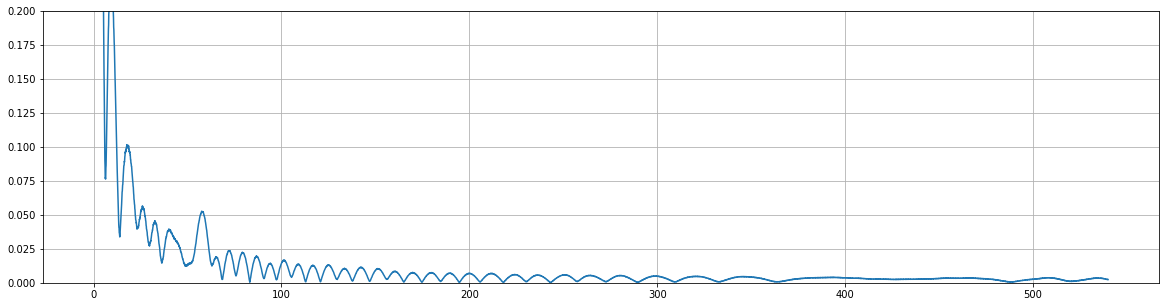

millis =  8825.666666666666
*** Sweep ***


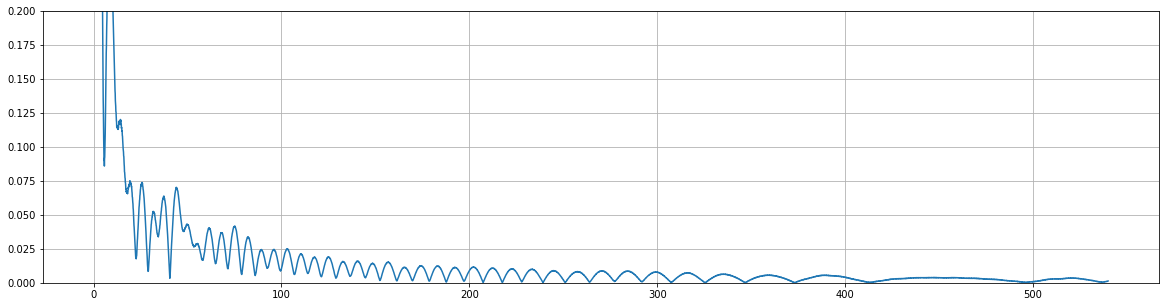

In [177]:
nc, sweepmillis_list = get_ir()

In [184]:
lens = get_dist(6000)
sweep_dist = get_real_dist()
ground_truth = true_ir_dist()

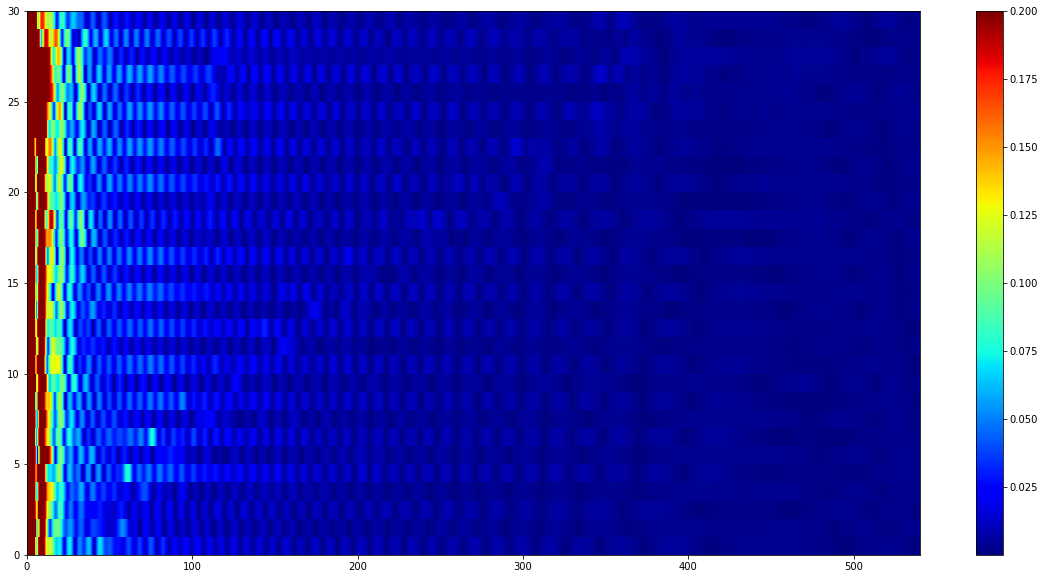

In [180]:
plt.figure(figsize=(20,10))
plt.imshow(pd.DataFrame(nc), vmax=0.2,cmap='jet', interpolation='nearest', origin='upper', extent=[lens[0],lens[-1],0,len(nc)], aspect='auto')
plt.colorbar()

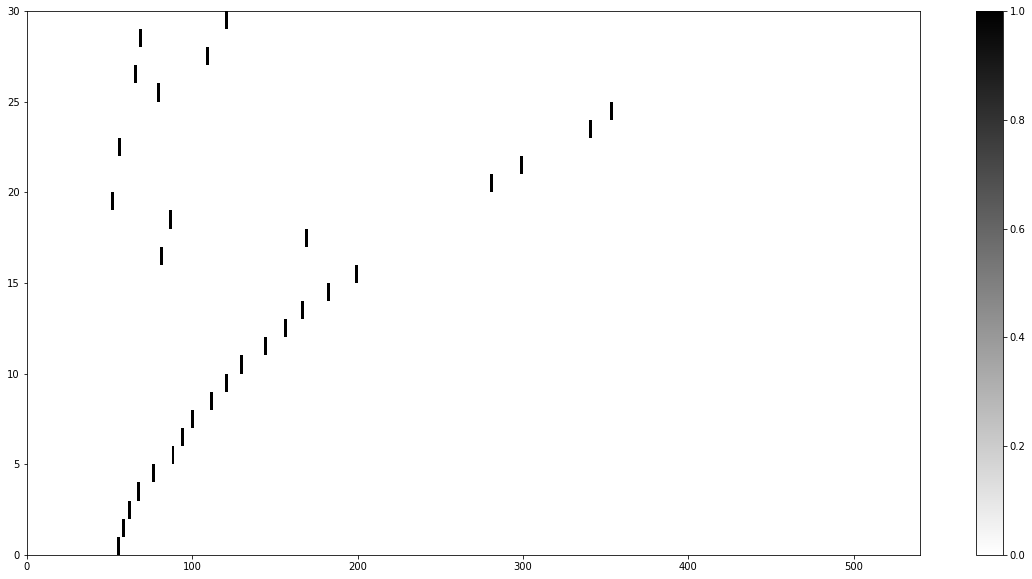

In [185]:
plt.figure(figsize=(20,10))
plt.imshow(ground_truth,cmap='binary', interpolation='nearest', origin='upper', extent=[lens[0],lens[-1],0,len(ground_truth)], aspect='auto')
plt.colorbar()

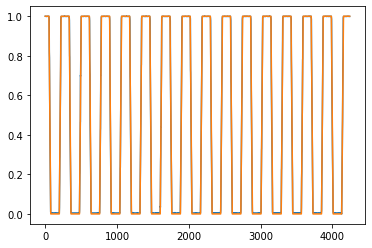

In [172]:
plt.plot(normalized_df)
plt.plot(approx_sig)

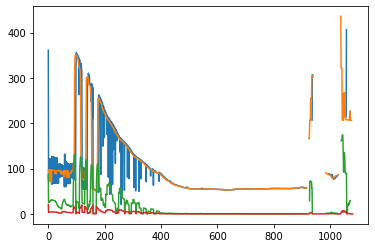

In [153]:
plt.plot(dist_list.dist)
plt.plot(dist_list.med)
plt.plot(dist_list.sd)
plt.plot(dist_list.velocity)

In [70]:
selected_session

[[datetime.datetime(2022, 4, 13, 17, 7, 38, 340000),
  datetime.datetime(2022, 4, 13, 17, 7, 54, 553000)],
 [datetime.datetime(2022, 4, 13, 17, 11, 7, 575000),
  datetime.datetime(2022, 4, 13, 17, 11, 23, 660000)],
 [datetime.datetime(2022, 4, 13, 17, 13, 44, 684000),
  datetime.datetime(2022, 4, 13, 17, 14, 2, 392000)]]